In [9]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
import cv2
import json
import pprint

In [14]:
# Specify data-base path
video_path = "RemoBIK.mp4"
data_path = "RemoBIK.data"

# Specify data-compare path
video_path2 = "FemaleBIK.mp4"
data_path2 = "FemaleBIK.data"

In [15]:
def readAllFramesDATA(file_path):
    keypoints_vec = []
    angles_vec = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i==0:
                metadata = json.loads(line)
            else:
                data = json.loads(line)
                keypoints_vec.append(data["keypoints"])
                angles_vec.append(data["angles"])
    #keypoints_vec = np.array(keypoints_vec).astype(float)
    angles_vec = np.array(angles_vec).astype(float)
    return metadata, angles_vec # return metadata, keypoints_vec, angles_vec

# Import data
metadata, angles_vec = readAllFramesDATA(data_path) # metadata, keypoints_vec, angles_vec = readAllFramesDATA(data_path) 
fps = metadata["fps"]
joint_names = metadata["keypoints_names"]
pairs_names = metadata["keypoints_pairs"]
angles_names = ["Knee <- Ankle -> Ground", "Hip <- Knee -> Ankle", "Shoulder <- Hip -> Knee", "Elbow <- Shoulder -> Hip", "Wrist <- Elbow -> Shoulder"]

# Import data
metadata2, angles_vec2 = readAllFramesDATA(data_path2) # metadata, keypoints_vec, angles_vec = readAllFramesDATA(data_path) 
fps = metadata2["fps"]
joint_names = metadata2["keypoints_names"]
pairs_names = metadata2["keypoints_pairs"]
angles_names = ["Knee <- Ankle -> Ground", "Hip <- Knee -> Ankle", "Shoulder <- Hip -> Knee", "Elbow <- Shoulder -> Hip", "Wrist <- Elbow -> Shoulder"]

# Preview metadata
pprint.pprint(metadata)
pprint.pprint(metadata2)

{'fps': 30,
 'frame_height': 1080,
 'frame_width': 1920,
 'keypoints_names': ['Left Ankle',
                     'Left Knee',
                     'Left Hip',
                     'Left Shoulder',
                     'Left Elbow',
                     'Left Wrist'],
 'keypoints_pairs': [['Left Shoulder', 'Left Elbow'],
                     ['Left Elbow', 'Left Wrist'],
                     ['Left Shoulder', 'Left Hip'],
                     ['Left Hip', 'Left Knee'],
                     ['Left Knee', 'Left Ankle']],
 'n_frames': 616,
 'n_points': 6,
 'summary': 'None',
 'video_name': 'Remo'}
{'fps': 29,
 'frame_height': 338,
 'frame_width': 600,
 'keypoints_names': ['Right Ankle',
                     'Right Knee',
                     'Right Hip',
                     'Right Shoulder',
                     'Right Elbow',
                     'Right Wrist'],
 'keypoints_pairs': [['Right Shoulder', 'Right Elbow'],
                     ['Right Elbow', 'Right Wrist'],
                  

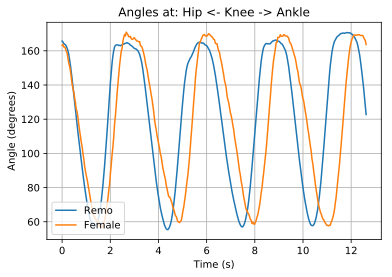

In [16]:
# Plot Angle
joint = "Left Knee" # Joint name
coord = 'x'
if coord == 'x':
    coord_num = 0
else:
    coord_num = 1

angle_name = "Hip <- Knee -> Ankle" # Joint name
angle_vec = angles_vec[:, angles_names.index(angle_name)] # Vertical axis
angle_vec2 = angles_vec2[:, angles_names.index(angle_name)] # Vertical axis
time_vec = np.linspace(0, len(angle_vec)*(1/fps), len(angle_vec)) # Horizontal axis
plt.figure()
plt.plot(time_vec, angle_vec, label = 'Remo')
plt.plot(time_vec, angle_vec2, label = 'Female')
plt.legend(loc='lower left')
plt.title("Angles at: {}".format(angle_name, coord))
plt.ylabel("Angle (degrees)")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

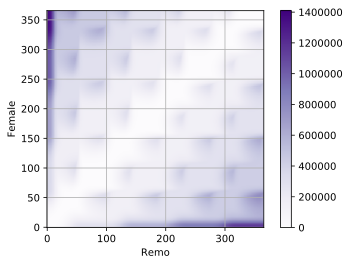

In [18]:
# DTW
#Calculates euclidian distances
distances = np.zeros((len(angle_vec), len(angle_vec2))) # same length
for i in range(len(angle_vec2)):
    for j in range(len(angle_vec)):
        distances[i,j] = (angle_vec[j]-angle_vec2[i])**2

def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Purples') 
    plt.gca().invert_yaxis()
    plt.xlabel("Remo")
    plt.ylabel("Female")
    plt.grid()
    plt.colorbar();
    
accumulated_cost = np.zeros((len(angle_vec2), len(angle_vec)))

# Calculates 1st column and 1st line to accumulates sum
for i in range(1, len(angle_vec)): 
    accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1]
    for i in range(1, len(angle_vec2)):
        accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]

# Check minimum
# Plots warping path
for i in range(1, len(angle_vec2)):
    for j in range(1, len(angle_vec)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
distance_cost_plot(accumulated_cost)

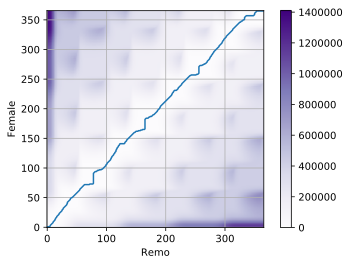

In [20]:
# Backtracking warping path
path = [[len(angle_vec)-1, len(angle_vec2)-1]]
i = len(angle_vec2)-1 
j = len(angle_vec)-1
while i > 0 and j > 0:
    if i == 0:
        j = j - 1
    elif j == 0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j - 1
        else:
            i = i - 1
            j= j- 1
    path.append([j, i])
path.append([0,0])

# Plots warping path 
path_x = [point[0] for point in path] # angle_vec
path_z = [point[1] for point in path] # angle_vec2

distance_cost_plot(accumulated_cost)
plt.plot(path_x, path_z);

In [21]:
# Calculates warping path
# Calculates distances between two series
def path_cost(angle_vec, angle_vec2, accumulated_cost, distances):
    path = [[len(angle_vec)-1, len(angle_vec2)-1]]
    cost = 0
    i = len(angle_vec2)-1
    j = len(angle_vec)-1
    while i > 0 and j > 0:
        if i == 0:
            j = j - 1
        elif j == 0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    for [angle_vec2, angle_vec] in path:
        cost = cost + distances[angle_vec, angle_vec2]
    return path, cost

365 163.71423948389935 : 365 122.73608867450628
364 166.10447019760616 : 365 122.73608867450628
363 166.7301402668534 : 365 122.73608867450628
362 167.8932186252603 : 365 122.73608867450628
361 168.9497958200513 : 365 122.73608867450628
360 168.9497958200513 : 365 122.73608867450628
359 168.9497958200513 : 365 122.73608867450628
358 169.01183756270305 : 365 122.73608867450628
357 169.38139588753955 : 365 122.73608867450628
356 169.38139588753955 : 365 122.73608867450628
355 169.38139588753955 : 365 122.73608867450628
354 169.1379998176214 : 365 122.73608867450628
353 169.1379998176214 : 364 127.90712204712281
352 169.1379998176214 : 363 133.21459128103828
351 169.26733544334422 : 362 138.21513752597855
350 169.01844135510694 : 361 142.66660332239624
350 169.01844135510694 : 360 146.97662248222017
350 169.01844135510694 : 359 151.01914887771696
349 167.77706465916435 : 358 154.88456571037898
348 166.78233771877385 : 357 158.24369895979342
347 165.1292924659379 : 357 158.24369895979342
3

200 129.75909203484895 : 213 59.2677581612636
199 131.2620248745186 : 212 60.61841724935334
198 133.90930302869222 : 211 62.315180531370174
197 138.20478044520195 : 210 64.17575849899424
196 140.73092520886516 : 209 66.21973379347287
195 142.54589760911452 : 208 68.26936909661617
194 146.06739572246303 : 207 70.54335018034175
193 148.53703653308213 : 206 72.76114985482604
192 151.62000570811128 : 205 75.06979983322816
191 153.94357497064146 : 204 77.66053002843364
191 153.94357497064146 : 203 80.46838138075736
190 155.9523557920769 : 202 83.1043571437184
190 155.9523557920769 : 201 86.27751092668711
189 158.99092488519437 : 200 89.24549679184372
188 159.965794612562 : 199 92.29160940651326
187 161.62194865540874 : 198 95.71761165275097
186 164.156917882313 : 197 99.07984787551936
186 164.156917882313 : 196 102.73731255708753
185 164.156917882313 : 195 106.4636373441702
184 164.40031395223116 : 194 110.14235703947736
183 166.50904899635657 : 193 113.88518750409656
182 166.74107923271706

57 81.96224564322634 : 66 163.48782537526472
56 78.23171106797936 : 65 163.40849300562346
55 73.6006142785637 : 64 163.16280284922328
55 73.6006142785637 : 63 162.29791807429487
54 70.06937738381896 : 62 160.18979877461194
53 65.92895236344977 : 61 157.1799691074521
52 63.12360813978731 : 60 152.91250938596326
51 60.781186986246084 : 59 147.41081821466852
50 58.6893644210758 : 58 141.55559657816318
49 56.79418857945887 : 57 134.66446094895986
48 56.636503994906384 : 56 127.47631690416841
47 57.1512581938055 : 55 120.1175862313869
46 57.05128532548045 : 54 112.73841940438535
45 57.58814412491476 : 53 105.58379733307277
44 58.62096314110389 : 52 99.15272993142582
43 59.42122594044921 : 51 92.7560823850589
42 60.9821239596826 : 50 86.86804217015072
41 60.91555953171576 : 50 86.86804217015072
40 61.415836068345804 : 49 81.34313975430791
39 62.95064664730234 : 48 76.52280255368652
39 62.95064664730234 : 47 71.96479514327484
38 63.28109121211558 : 46 68.25137852390083
37 65.22485943116808 : 

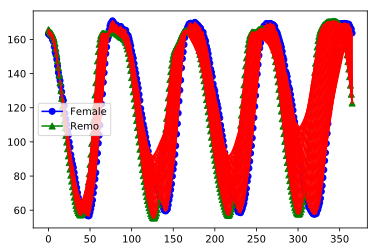

In [41]:
# Plots angles and distances
plt.plot(angle_vec2, 'bo-' ,label = 'Female')
plt.plot(angle_vec, 'g^-', label = 'Remo')
plt.legend();
paths = path_cost(angle_vec2, angle_vec, accumulated_cost, distances)[0]
for [map_angle_vec2, map_angle_vec] in paths:
    print (map_angle_vec2, angle_vec2[map_angle_vec2], ":", map_angle_vec, angle_vec[map_angle_vec])
    
    plt.plot([map_angle_vec2, map_angle_vec], [angle_vec2[map_angle_vec2], angle_vec[map_angle_vec]], 'r')
